# Masinsko ucenje, Elektronski fakultet 2021

## Projekat 2

### Aleksandar Gavric, Nikola Blagojevic


In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
%matplotlib inline

# Import the Movies dataset
movies = pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [2]:
# Import the ratings dataset
ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
# Print the number of records and the total number of movies
print('Dataset sadrzi: ', len(ratings), ' ocena za ', len(movies), ' filmova.')

Dataset sadrzi:  100836  ocena za  9742  filmova.


In [4]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings
# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


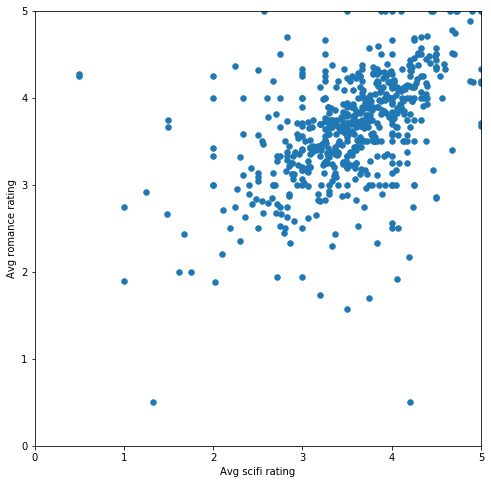

In [6]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)
# Plot the scatterplot
draw_scatterplot(genre_ratings['avg_scifi_rating'],'Avg scifi rating', genre_ratings['avg_romance_rating'], 'Avg romance rating')

In [7]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset
# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)
# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  162


,index,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


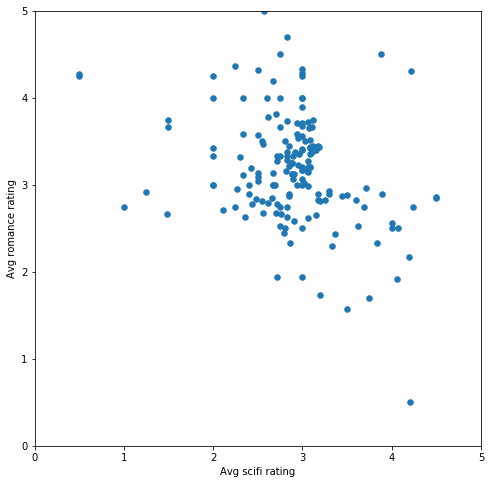

In [8]:
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

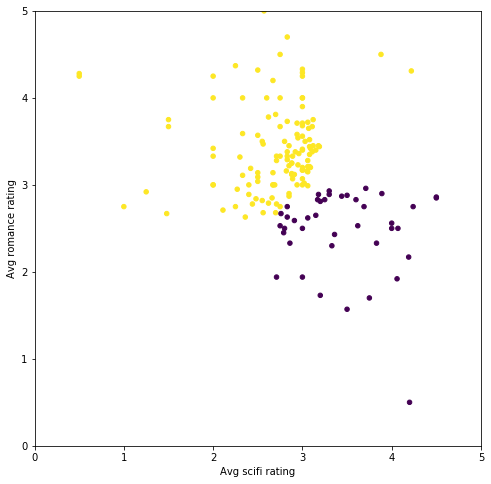

In [9]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values
# Import KMeans
from sklearn.cluster import KMeans
# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)
# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)
# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

# Plot
draw_clusters(biased_dataset, predictions)

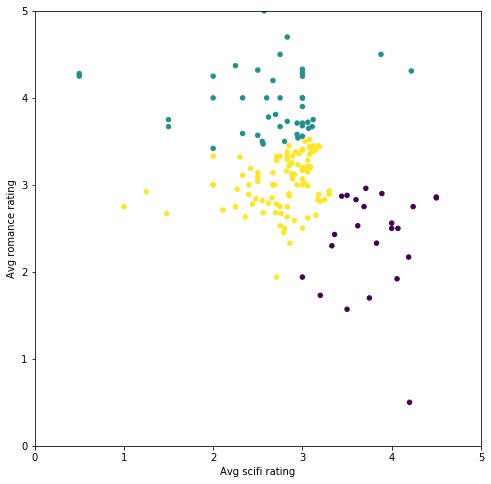

In [10]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)
# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_2)


C:\Users\aleks\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (157) found smaller than n_clusters (162). Possibly due to duplicate points in X.
  return_n_iter=True)


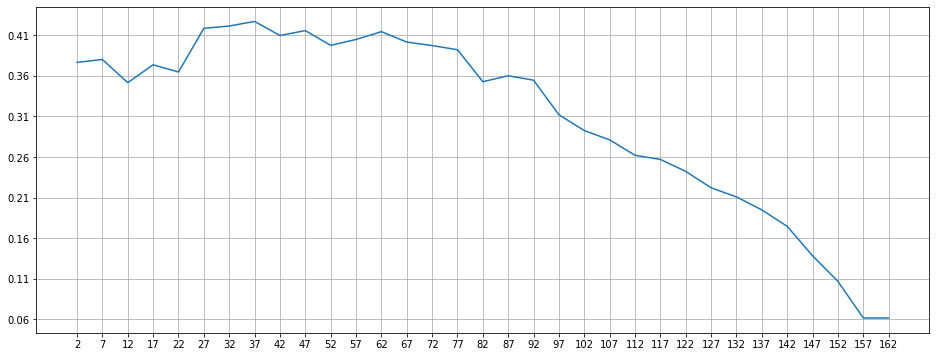

In [11]:
# Selecting our dataset to study
df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]
# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)
# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg
# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)
# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

Najbolje za K: 7, 32, 36, 47. Biramo K = 7 (da bi mogli i da vizualizujemo laske). Koristimo Silhouette Score.

The range of Silhouette score is [-1, 1]. 

Its analysis is as follows −
+1 Score − Near +1 Silhouette score indicates that the sample is far away from its neighboring cluster.
0 Score − 0 Silhouette score indicates that the sample is on or very close to the decision boundary separating two neighboring clusters.


-1 Score − 1 Silhouette score indicates that the samples have been assigned to the wrong clusters.
The calculation of Silhouette score can be done by using the following formula
silhouettescore=(p−q)/max(p,q)
silhouettescore=(p−q)/max(p,q)
Here, p = mean distance to the points in the nearest cluster
And, q = mean intra-cluster distance to all the points.

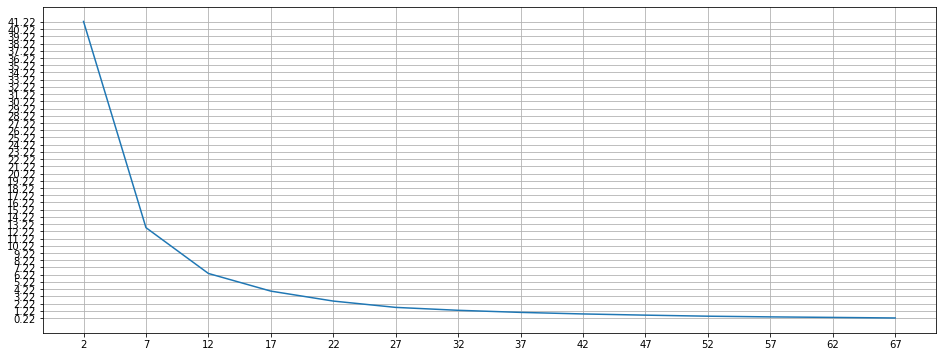

In [12]:
def clustering_errorsMSE(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    cluster_centers = kmeans.cluster_centers_
    errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data, predictions)]
    return sum(errors)

possible_k_values = range(2, 72, 5)
# Calculate error values for all k values we're interested in
errors1_per_k = [clustering_errorsMSE(k, X) for k in possible_k_values]
# Plot the each value of K vs. the MSE at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors1_per_k)
# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors1_per_k), 2), max(errors1_per_k))
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

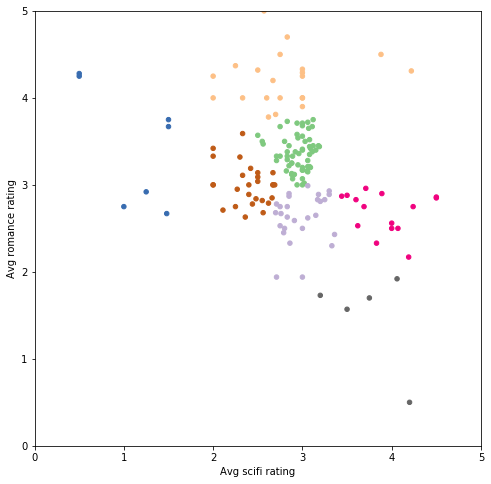

In [13]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

In [16]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[100:106, 100:110]

dataset dimensions:  (610, 9719) 

Subset example:


title,3 dev adam (Three Giant Men) (1973),3-Iron (Bin-jip) (2004),30 Days of Night (2007),30 Minutes or Less (2011),300 (2007),3000 Miles to Graceland (2001),300: Rise of an Empire (2014),31 (2016),35 Up (1991),"39 Steps, The (1935)"
userId,,,,,,,,,,
101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,NaN,4.0,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN
106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Conversion to sparse csr matrix
sparse_ratings = csr_matrix(pd.SparseDataFrame(user_movie_ratings).to_coo())

C:\Users\aleks\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  
C:\Users\aleks\Anaconda3\lib\site-packages\pandas\core\frame.py:3456: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.

  return klass(values, index=self.index, name=items, fastpath=True)


In [21]:
# 20 clusters
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)
predictions

array([ 9,  3,  3,  9, 11, 11,  0, 11,  3,  3, 11,  3,  3, 11,  0,  3,  0,
        0,  9,  0,  0,  3,  3,  3,  3, 11,  3,  0,  3,  3,  3, 11, 11,  3,
        3,  3, 11, 11,  9, 11,  0,  9, 11,  3,  4, 11,  3,  3,  3,  3,  9,
        0,  3, 11,  3, 11, 14, 11,  9,  3,  3,  0,  0,  4,  3,  6,  3, 19,
        3,  3,  3,  3,  0,  3,  3,  3,  3,  3,  3,  0, 11,  0,  3,  9,  3,
        3,  3,  3,  3,  3,  4,  3, 11, 11,  9,  3,  3,  3, 11,  3,  3, 11,
        0,  0, 16,  3, 11,  3, 11,  3,  0,  3,  3,  3,  3,  3, 11,  3,  0,
        3, 11,  0,  3,  3,  0, 11,  3,  3,  0, 11,  3,  0, 11, 11,  9, 11,
        9,  3,  3,  9,  0, 11,  3, 11, 11,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  9,  3,  3,  3,  9,  3, 11,  3,  3,  3,  0,  0,  3,  0, 11,
        3,  3, 11, 11,  3, 11,  4,  3, 11,  3, 11,  4,  3,  3,  3,  9,  0,
        3,  3,  3, 11, 11,  3,  3,  9,  3,  3,  9,  9,  0,  9,  9,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  0,  3,  3,  3,  3,  9,  3,  4,  0,  9,
        0,  3,  3,  3,  4

In [28]:
# Function to get the genre ratings
def get_genre_ratings1(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']]
        avg_genre_votes_per_user = genre_votes_per_user.groupby(['userId'])['rating'].mean().round(2)
        cnt_genre_votes_per_user = genre_votes_per_user.groupby(['userId'])['rating'].count()
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user, cnt_genre_votes_per_user], axis=1)
        
    #genre_ratings.columns = column_names
    return genre_ratings
# Calculate the average rating of romance and scifi movies
genre_ratings1 = get_genre_ratings1(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'cnt_romance_rating','avg_scifi_rating', 'cnt_scifi_rating'])
genre_ratings1.head()

,rating,rating,rating,rating
1,4.31,26.0,4.22,40.0
2,4.50,1.0,3.88,4.0
3,0.50,5.0,4.20,15.0
4,3.38,58.0,2.83,12.0
5,3.09,11.0,2.50,2.0


In [29]:
genre_ratings1.isna().sum()

rating    4
rating    4
rating    5
rating    5
dtype: int64